In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# 한글 폰트 설정을 위한 코드 (이미 설정하셨다면 생략)
plt.rc('font', family='Malgun Gothic') # Windows
# plt.rc('font', family='AppleGothic') # Mac
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

In [59]:
df = pd.read_csv('C:/Users/sopi0/codes/korea-tour-recommender/data/2024_6차_전처리.csv')
df.head()

,아이디,성별,연령별,한국 방문횟수(카테고리),문1-1. 한국여행 관심 계기_1,문3-1. 고려한 관광활동_1,문3-2. 고려한 관광인프라_1,숙박시설_그룹,여행동반자_그룹,방문 지역 수,...,국내 교통비_비율,체험/활동비_비율,뷰티/의료비_비율,여행 서비스비_비율,숙박비_비율,쇼핑비_비율,기타 비용_비율,여행 패턴,"문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)",문9-3. 총 체재기간_61일 이상 결측
0,57,2,5,4,6,1.0,3,호텔,가족형,1,...,0.064935,0.021645,0.0,0.004329,0.432900,0.216450,0.000000,서울 심층형,451.666667,6.0
1,58,2,4,4,6,9.0,6,호텔,가족형,1,...,0.028705,0.004784,0.0,0.000096,0.239212,0.574108,0.009568,서울 단기형,272.935000,5.0
2,59,2,3,3,6,10.0,2,호텔,단체형,1,...,0.054336,0.043469,0.0,0.000217,0.217344,0.434688,0.010867,서울 심층형,177.650000,6.0
3,60,1,2,1,7,9.0,2,호텔,혼자형,1,...,0.134357,0.000000,0.0,0.001919,0.383877,0.191939,0.000000,서울 심층형,153.780000,6.0
4,61,2,2,4,2,1.0,4,호텔,가족형,2,...,0.051269,0.000000,0.0,0.000256,0.128172,0.769034,0.012817,서울 단기형,329.460000,5.0


In [60]:
df.shape

(10137, 21)

In [61]:
df.columns

Index(['아이디', '성별', '연령별', '한국 방문횟수(카테고리)', '문1-1. 한국여행 관심 계기_1',
       '문3-1. 고려한 관광활동_1', '문3-2. 고려한 관광인프라_1', '숙박시설_그룹', '여행동반자_그룹',
       '방문 지역 수', '식비_비율', '국내 교통비_비율', '체험/활동비_비율', '뷰티/의료비_비율', '여행 서비스비_비율',
       '숙박비_비율', '쇼핑비_비율', '기타 비용_비율', '여행 패턴',
       '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)', '문9-3. 총 체재기간_61일 이상 결측'],
      dtype='object')

## 실험1) '총 체재기간' 제거

In [62]:
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score

In [63]:
features = ['성별', '연령별', '한국 방문횟수(카테고리)', '문1-1. 한국여행 관심 계기_1',
       '문3-1. 고려한 관광활동_1', '문3-2. 고려한 관광인프라_1',
       '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)', 
       #'문9-3. 총 체재기간_61일 이상 결측',
       '숙박시설_그룹', '여행동반자_그룹', '방문 지역 수', '여행 패턴',
       #'식비_비율', '국내 교통비_비율', '체험/활동비_비율',
       #'뷰티/의료비_비율', '여행 서비스비_비율', '숙박비_비율', '쇼핑비_비율', '기타 비용_비율'
       ] # '아이디'를 제외한 모든 변수

df_model = df[features].copy()

In [64]:
# 2. 수치형 데이터 스케일링 (표준화) => 순위형 범주형 변수도 포함해봄.
scaler = StandardScaler()
num_cols = ['연령별', '한국 방문횟수(카테고리)', '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)',
            #'문9-3. 총 체재기간_61일 이상 결측', 
            '방문 지역 수'
            #'식비_비율', '국내 교통비_비율', 
            #'체험/활동비_비율', '뷰티/의료비_비율', '여행 서비스비_비율', 
            #'숙박비_비율', '쇼핑비_비율', '기타 비용_비율'
            ]
df_model[num_cols] = scaler.fit_transform(df_model[num_cols])

In [65]:
# 3. 범주형 변수의 인덱스 추출 (K-prototype 입력용)
# 모델은 어떤 컬럼이 범주형인지 인덱스 번호로 인식합니다.
cat_cols = ['성별', '문1-1. 한국여행 관심 계기_1','문3-1. 고려한 관광활동_1', 
            '문3-2. 고려한 관광인프라_1','숙박시설_그룹', '여행동반자_그룹','여행 패턴']
df_model[cat_cols] = df_model[cat_cols].astype('object')

cat_idx = [df_model.columns.get_loc(col) for col in cat_cols]

In [66]:
# 4. 데이터를 Numpy Array로 변환 (kmodes 라이브러리 요구사항)
matrix = df_model.values

## 실루엣 기법

In [67]:
# --- 1. 실루엣 계산을 위한 데이터 준비 ---
# 실루엣 점수 계산 함수는 범주형 변수를 숫자로 인식해야 하므로 임시 변환이 필요합니다.
df_silhouette = df_model.copy()
le = LabelEncoder()

for col in cat_cols:
    df_silhouette[col] = le.fit_transform(df_silhouette[col])

In [68]:
# --- 2. K값 변화에 따른 실루엣 점수 계산 ---
sil_scores = []
cost = []
n_clusters = range(2, 11) # 2개에서 6개 사이 탐색

for k in n_clusters:
    # 모델 학습
    kproto = KPrototypes(n_clusters=k, init='Cao', random_state=42, n_jobs=-1)
    clusters = kproto.fit_predict(matrix, categorical=cat_idx)
    cost.append(kproto.cost_)
    
    # 실루엣 점수 계산 (여기서는 변환된 df_silhouette를 사용)
    # 주의: K-prototype의 내부 거리 로직과 100% 일치하지는 않지만, 군집의 품질을 판단하는 좋은 지표가 됩니다.
    score = silhouette_score(df_silhouette, clusters)
    sil_scores.append(score)
    print(f"Cluster k={k}, Silhouette Score: {score:.4f}")

Cluster k=2, Silhouette Score: 0.0417
Cluster k=3, Silhouette Score: 0.0264
Cluster k=4, Silhouette Score: 0.0267
Cluster k=5, Silhouette Score: 0.0138
Cluster k=6, Silhouette Score: 0.0018
Cluster k=7, Silhouette Score: 0.0020
Cluster k=8, Silhouette Score: -0.0035
Cluster k=9, Silhouette Score: -0.0036
Cluster k=10, Silhouette Score: -0.0149


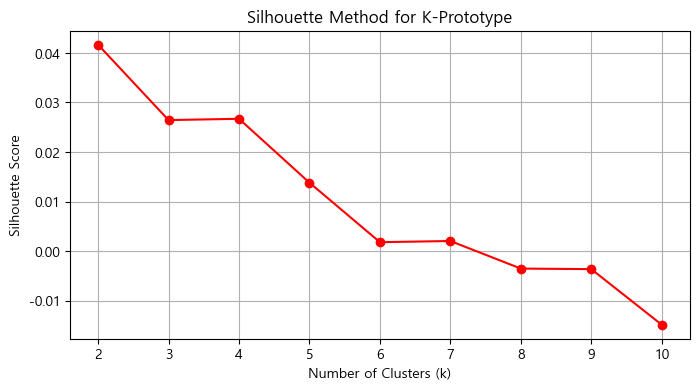

In [69]:
# --- 3. 실루엣 그래프 시각화 ---
plt.figure(figsize=(8, 4))
plt.plot(n_clusters, sil_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for K-Prototype')
plt.grid(True)
plt.show()

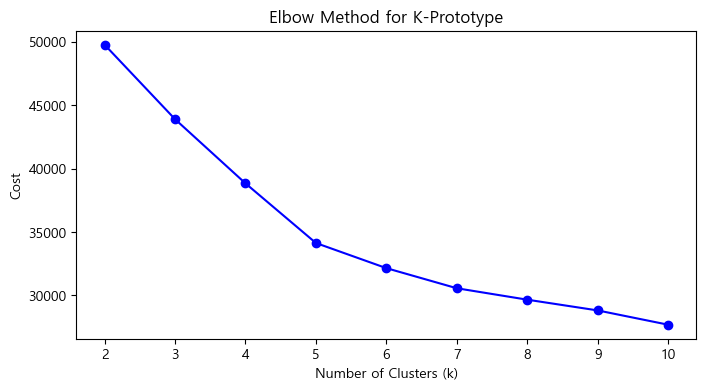

In [70]:
# Elbow Plot 시각화
plt.figure(figsize=(8, 4))
plt.plot(n_clusters, cost, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for K-Prototype')
plt.show()

In [76]:
for k in n_clusters:
    print(f"k = {k}, cost = {cost[k-2]}")

k = 2, cost = 49761.567472934286
k = 3, cost = 43889.104258152875
k = 4, cost = 38827.54652395911
k = 5, cost = 34124.10506794166
k = 6, cost = 32142.399704120347
k = 7, cost = 30556.70823769277
k = 8, cost = 29655.459117982184
k = 9, cost = 28808.363104819542
k = 10, cost = 27681.81375016682


In [79]:
kproto = KPrototypes(n_clusters=5, init='Cao', random_state=42, n_jobs=-1)
clusters = kproto.fit_predict(matrix, categorical=cat_idx)

In [80]:
pd.Series(clusters).value_counts().sort_index()

0    2040
1     424
2     934
3    4333
4    2406
Name: count, dtype: int64

In [81]:
# 원본 데이터에 클러스터 결과 붙이기
df_model['Cluster'] = clusters
# 클러스터별 중심점(Centroids) 확인
print(kproto.cluster_centroids_)

[['1.1728298193611997' '-0.501786765872678' '-0.14899552843947456'
  '-0.1513191975938025' '2' '1' '2.0' '6' '호텔' '가족형' '서울 단기형']
 ['0.3724025553072712' '0.3585916991580353' '3.6661020458529667'
  '-0.307589128097335' '2' '7' '2.0' '6' '호텔' '혼자형' '서울 단기형']
 ['-0.08116989725817209' '-0.5304100460699046' '-0.2870978443552738'
  '2.4157078595577555' '2' '1' '4.0' '6' '호텔' '가족형' '서울 심층형']
 ['-0.6986125444610913' '-0.5421478185677998' '-0.21176019181973393'
  '-0.2347776299145632' '2' '1' '5.0' '6' '호텔' '친구형' '서울 심층형']
 ['0.2296048729184818' '1.5445268507152805' '-0.026920237590354164'
  '-0.3324483445563124' '2' '2' '2.0' '6' '호텔' '가족형' '서울 단기형']]


## 그리드 서치

In [82]:
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score

In [83]:
features = ['성별', '연령별', '한국 방문횟수(카테고리)', '문1-1. 한국여행 관심 계기_1',
       '문3-1. 고려한 관광활동_1', '문3-2. 고려한 관광인프라_1',
       '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)', 
       #'문9-3. 총 체재기간_61일 이상 결측',
       '숙박시설_그룹', '여행동반자_그룹', '방문 지역 수', '여행 패턴',
       #'식비_비율', '국내 교통비_비율', '체험/활동비_비율',
       #'뷰티/의료비_비율', '여행 서비스비_비율', '숙박비_비율', '쇼핑비_비율', '기타 비용_비율'
       ] # '아이디'를 제외한 모든 변수

df_model = df[features].copy()

In [84]:
# 2. 수치형 데이터 스케일링 (표준화) => 순위형 범주형 변수도 포함해봄.
scaler = StandardScaler()
num_cols = ['연령별', '한국 방문횟수(카테고리)', '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)',
            #'문9-3. 총 체재기간_61일 이상 결측', 
            '방문 지역 수'
            #'식비_비율', '국내 교통비_비율', 
            #'체험/활동비_비율', '뷰티/의료비_비율', '여행 서비스비_비율', 
            #'숙박비_비율', '쇼핑비_비율', '기타 비용_비율'
            ]
df_model[num_cols] = scaler.fit_transform(df_model[num_cols])

In [85]:
# 3. 범주형 변수의 인덱스 추출 (K-prototype 입력용)
# 모델은 어떤 컬럼이 범주형인지 인덱스 번호로 인식합니다.
cat_cols = ['성별', '문1-1. 한국여행 관심 계기_1','문3-1. 고려한 관광활동_1', 
            '문3-2. 고려한 관광인프라_1','숙박시설_그룹', '여행동반자_그룹','여행 패턴']
df_model[cat_cols] = df_model[cat_cols].astype('object')

cat_idx = [df_model.columns.get_loc(col) for col in cat_cols]

In [86]:
# 4. 데이터를 Numpy Array로 변환 (kmodes 라이브러리 요구사항)
matrix = df_model.values

In [87]:
# --- 1. 실루엣 계산을 위한 데이터 준비 ---
# 실루엣 점수 계산 함수는 범주형 변수를 숫자로 인식해야 하므로 임시 변환이 필요합니다.
df_silhouette = df_model.copy()
le = LabelEncoder()

for col in cat_cols:
    df_silhouette[col] = le.fit_transform(df_silhouette[col])

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes

# -----------------------------
# 1) 탐색 그리드 설정
# -----------------------------
k_list = list(range(2, 16))
gamma_list = [0.1, 0.25, 0.5, 1, 2, 4, 8, 16]  # 필요하면 더 촘촘히

# 결과 저장용
rows = []
# 실루엣 점수 저장
sil_scores = []

# -----------------------------
# 2) k x gamma 그리드 탐색
# -----------------------------
for k in k_list:
    for g in gamma_list:
        kproto = KPrototypes(
            n_clusters=k,
            init='Cao',
            # n_init=20,          # 안정성 위해 권장(기본 10보다 크게)
            # max_iter=100,
            gamma=g,            # <-- 여기서 gamma 지정
            verbose=0,
            random_state=42
        )
        labels = kproto.fit_predict(matrix, categorical=cat_idx)
        
        # cost
        cost = kproto.cost_
        
        # 실루엣 점수 계산 (여기서는 변환된 df_silhouette를 사용)
        # 주의: K-prototype의 내부 거리 로직과 100% 일치하지는 않지만, 군집의 품질을 판단하는 좋은 지표가 됩니다.
        score = silhouette_score(df_silhouette, labels)
        sil_scores.append(score)
        print(f"Cluster k={k}, Silhouette Score: {score:.4f}, cost: {cost:.4f}")


        # 군집 크기 불균형 지표(해석에 유용)
        counts = np.bincount(labels, minlength=k)
        proportions = counts / counts.sum()
        max_cluster_ratio = proportions.max()  # 가장 큰 군집 비율 (너무 크면 불균형)

        # 엔트로피(균형도): 클수록 더 고르게 퍼짐(최대는 log(k))
        eps = 1e-12
        entropy = -(proportions * np.log(proportions + eps)).sum()
        entropy_norm = entropy / np.log(k)     # 0~1로 정규화(1에 가까울수록 균형)

        rows.append({
            "k": k,
            "gamma": g,
            "cost": cost,
            "silhouette_score": score,
            "max_cluster_ratio": max_cluster_ratio,
            "entropy_norm": entropy_norm
        })

result = pd.DataFrame(rows)


Cluster k=2, Silhouette Score: 0.0443, cost: 34784.8862
Cluster k=2, Silhouette Score: 0.0440, cost: 40411.3048
Cluster k=2, Silhouette Score: 0.0417, cost: 49761.5675
Cluster k=2, Silhouette Score: 0.0439, cost: 68211.3867
Cluster k=2, Silhouette Score: 0.0626, cost: 103404.5166
Cluster k=2, Silhouette Score: 0.0594, cost: 176531.5938
Cluster k=2, Silhouette Score: 0.0332, cost: 321062.1708
Cluster k=2, Silhouette Score: 0.0332, cost: 602622.1708
Cluster k=3, Silhouette Score: 0.0260, cost: 29078.0103
Cluster k=3, Silhouette Score: 0.0260, cost: 34683.3402
Cluster k=3, Silhouette Score: 0.0264, cost: 43889.1043
Cluster k=3, Silhouette Score: 0.0326, cost: 62294.0246
Cluster k=3, Silhouette Score: 0.0290, cost: 97134.8003
Cluster k=3, Silhouette Score: 0.0048, cost: 168449.3199
Cluster k=3, Silhouette Score: 0.0120, cost: 302327.1057
Cluster k=3, Silhouette Score: 0.0117, cost: 565941.1261
Cluster k=4, Silhouette Score: 0.0355, cost: 23874.3341
Cluster k=4, Silhouette Score: 0.0266, co

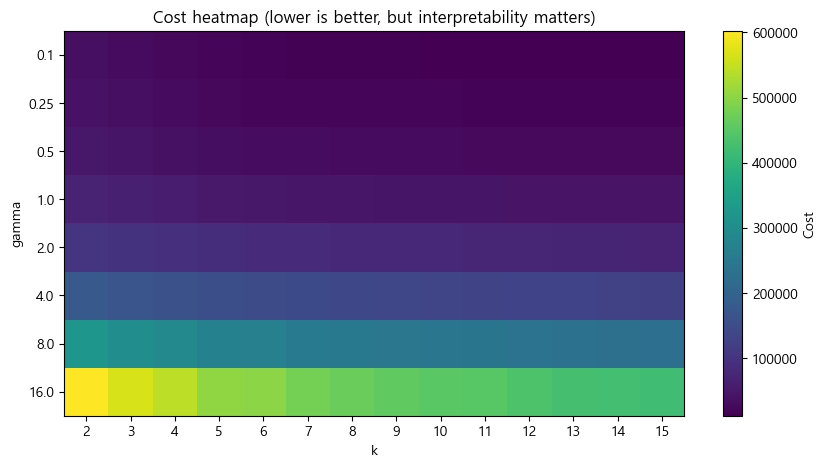

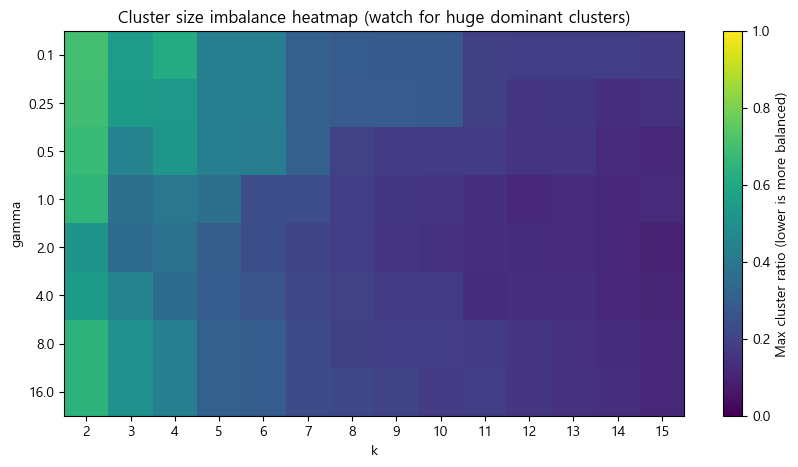

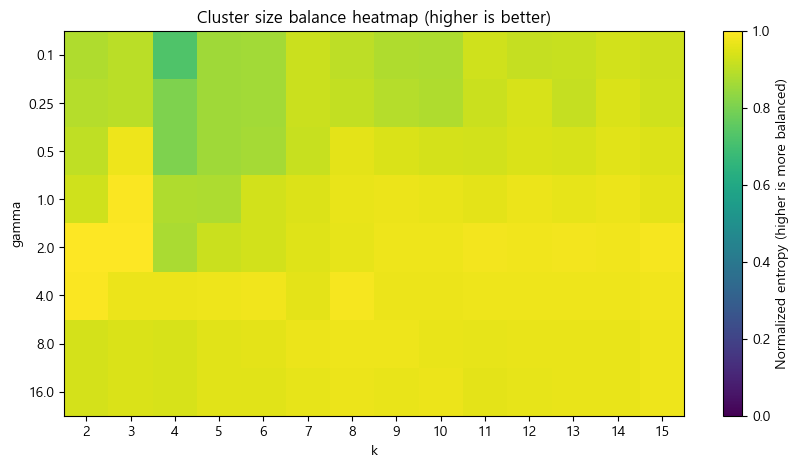

In [91]:

# -----------------------------
# 3) 결과 확인: (a) cost heatmap 형태로 보기
# -----------------------------
pivot_cost = result.pivot(index="gamma", columns="k", values="cost").sort_index()
plt.figure(figsize=(10, 5))
plt.imshow(pivot_cost.values, aspect='auto')
plt.yticks(range(len(pivot_cost.index)), pivot_cost.index)
plt.xticks(range(len(pivot_cost.columns)), pivot_cost.columns)
plt.colorbar(label="Cost")
plt.xlabel("k")
plt.ylabel("gamma")
plt.title("Cost heatmap (lower is better, but interpretability matters)")
plt.show()

# -----------------------------
# 4) 결과 확인: (b) 불균형/균형도도 같이 보기
# -----------------------------
pivot_max = result.pivot(index="gamma", columns="k", values="max_cluster_ratio").sort_index()
plt.figure(figsize=(10, 5))
plt.imshow(pivot_max.values, aspect='auto', vmin=0, vmax=1)
plt.yticks(range(len(pivot_max.index)), pivot_max.index)
plt.xticks(range(len(pivot_max.columns)), pivot_max.columns)
plt.colorbar(label="Max cluster ratio (lower is more balanced)")
plt.xlabel("k")
plt.ylabel("gamma")
plt.title("Cluster size imbalance heatmap (watch for huge dominant clusters)")
plt.show()

pivot_ent = result.pivot(index="gamma", columns="k", values="entropy_norm").sort_index()
plt.figure(figsize=(10, 5))
plt.imshow(pivot_ent.values, aspect='auto', vmin=0, vmax=1)
plt.yticks(range(len(pivot_ent.index)), pivot_ent.index)
plt.xticks(range(len(pivot_ent.columns)), pivot_ent.columns)
plt.colorbar(label="Normalized entropy (higher is more balanced)")
plt.xlabel("k")
plt.ylabel("gamma")
plt.title("Cluster size balance heatmap (higher is better)")
plt.show()